# Lecture_3: Supervised Learning Algorithms 
                                                     
In this module we are going to mimic the [WxChallenge](https://www.wxchallenge.com/) (with slight changes for time constraints)
  - Use regression to predict the high/low temperature of a given city
  - Use classification to predict whether precipitation will occur at a given city.
  - Relatively straight forward problem that is familiar to many meteorologists 
  - Learn the ML process on one city (Roanoke, NC) and apply you knowledge to an entirely different prediction problem or to another city, it is up to you!

<br>

These are the correct data, just in case: 

```
#Download tutorial file from zenodo
!wget -O "kroa_processed_data.csv"  "https://zenodo.org/record/5834903/files/kroa_processed_data.csv?download=1"

```


# Applying Supervised Machine Learning to Surface Weather Observations #

In this tutorial, we will explore different approaches to supervized machine learning using surface weather observations. This notebook will utilize the pre-processing techniques from the previous module to train basic ML models and evaluate model performance. 

A brief introduction to ML models will be provided in lecture-like materials, with links to (hopefully) helpul resources. You will have the oppotuntiy to put into practice some the machine learning techniques demonstrated in this module at the end of the course  through a coding exercises.

Please cite the notebook as follows:

    McNicholas, C., 2022: "Appying Supervised Machine Learning to Surface Weather Observations"

The data for this tutorial can be cited as: 

    McGovern, A., Burke, A., Harrison, D., and G. M. Lackmann, 2020: A Machine Learning Tutorial for Operational Forecasting: Part I. Wea. Forecasting, In Press 


*Before we begin lets get a bit of audience background. Respond anonymously to the poll below.*

**[Audience Poll](https://pollev.com/calliemcni772)**
-------------------------------------------------------------------------------

<br>


# Module Setup

Import relevant python libraries. 


*   Matplotlib (plotting)
*   Pandas (data analysis)
*   Numpy (array, matrix, and mathematical functions)
*   Xarray (analysis of multi-dimensional data)
*   sklearn (machine learning models)
*   XGBoost (fast gradient boosting model)


<br>

In [1]:
#Import relevant libraries and install netcdf4
import pandas as pd
import numpy as np
import gdown
#install netcdf4 (for xarray)
! pip install netcdf4
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
from datetime import datetime
#Feature selection
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression,mutual_info_regression
from sklearn.feature_selection import SelectFromModel
#Feature Scaling
from sklearn.preprocessing import MinMaxScaler
#Machine learning models
from sklearn.linear_model import LinearRegression #linear models
from sklearn import svm #support vectorr machine
#Ensemble Decision Tree Algorithms
from sklearn.ensemble import RandomForestRegressor 
#Instal Extreme gradient boosting
!pip install xgboost
import xgboost as xgb
#ML Aggregation (Average methods)
from sklearn.ensemble import VotingRegressor
#ML Stacking (Combine Estimators sequentially)
from sklearn.ensemble import StackingRegressor
#Add multiple output support for Supervised ML
from sklearn.multioutput import MultiOutputRegressor
#Simple Neurel Net (For comparison with ensemble techniques)
from sklearn.neural_network import MLPRegressor
#Model evaluation
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
from sklearn.metrics import plot_roc_curve
import warnings
warnings.filterwarnings('ignore')



### Prevent Auto-scrolling

The next cell prevents output in the notebook from being nested in a scroll box

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;

<IPython.core.display.Javascript object>

## Import data

The next cell retrieves all of the data that will be used by this notebook. If anything crashes, it will probably be here.

In [3]:
!wget -O "kroa_processed_data.csv"  "https://zenodo.org/record/5834903/files/kroa_processed_data.csv?download=1"

# Alternate if zenodo is down uncomment below:

#import gdown
#MLurl = "https://drive.google.com/u/0/uc?id=107r52s7aMkVmyxHaximfcNQBZJJ-Cd3b&export=download"
#MLoutput = 'kroa_processed_data.csv'
#gdown.download(MLurl, MLoutput, quiet=False) 


--2022-01-12 18:51:40--  https://zenodo.org/record/5834903/files/kroa_processed_data.csv?download=1
Resolving zenodo.org (zenodo.org)... 137.138.76.77
Connecting to zenodo.org (zenodo.org)|137.138.76.77|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 62226641 (59M) [text/plain]
Saving to: ‘kroa_processed_data.csv’

kroa_processed_data 100%[===================>]  59.34M  18.7MB/s    in 3.2s    

2022-01-12 18:51:45 (18.7 MB/s) - ‘kroa_processed_data.csv’ saved [62226641/62226641]



<br>


# Tutorial Overview


<br>

**Brief:** 
1. What is ML/Artificial Intelligence (AI) 
2. General ML Pipeline
3. Prediction Problem and Dataset Information
4. Data Visualization

**More in Depth:**
5. Data Pre-processing
  - Partitioning Data
  - Transforming and Scaling Data

6. Machine Learning Models
  - Scoring 
  - Linear Methods
  - Tree-based 
  - Ensemble and Aggregate Methods

7. Model evaluation
  - Feature Analysis
  - Accuracy and Reliability

8. Multi-output Regression

9. Classification

10. Excercises

[Here](https://towardsdatascience.com/list-of-free-must-read-machine-learning-books-89576749d2ff) is a list of free books about ML from a statistical perspective.
 


<br>


# **1. What is ML/AI**



<br>

### Differences between Traditional Programming and ML

<img src="https://images.contentful.com/pqts2v0qq7kz/4Mcjw0xAi4auqweOQQyWCu/80236c975b5026ec67e61f767a646b45/machine_learning_flow--4j88rajonr_s600x0_q80_noupscale.png" width="400">


<br>


# **2. General ML pipeline**




You can simply throw data at a ML model and expect something to stick, right? 

NO! *(Well maybe but you shouldn't!)*

<img src="https://imgs.xkcd.com/comics/machine_learning.png" width="350">


### The (brief) end-to-end process for using ML models

*Define the Problem*
  - Look at the data and forecasting task to see if ML is appropriate. Do existing methods produce skillful results? If so then ML may not be necessary.
  - Is the data normally distributed, correlated, etc.? **Do you have enough data if what you are trying to predict is rare?**

*Separate Data* 
  - Split your data into **at least two independent sets**: training and testing
  - Possibly use validation set to tune ML models before applying them to the testing set. 

*Data Pre-processing* 
  - After determining ML would benefit your problem domain, transform the data to be more amenable for ML
  - Find out what shape the data needs to be
  - If necessary, normalize/scale data
  
### ***The above steps are at least 80% of the work when working with ML models***


*Model Training*
  - Optimize ML model(s) using the **training dataset only**

*Model Deployment*
  - Apply the trained ML model to the **testing dataset only** 

*Model Evaluation*
  - Use verification metrics and subjective evaluations to determine the skill of the ML model for a given predictive task.  

*Model Interpretation*
  - Use different interpretation techniques (variable importance, learning curves, etc.) to determine **why** the ML model(s) make decisions and whether the model(s) can be improved.
  - Evaluate if the decision-making process is reasonable
  - Allow end-users to better trust the ML decisions

<br>

## These steps are applicable for both ML and DL models. More details about the ML pipeline can be found [here](https://www.oreilly.com/library/view/building-machine-learning/9781492053187/ch01.html). 

<br>

<br>


# **3. Prediction Problem and Dataset Information**

*Define the problem*

We want to use regression to predict the high/low temperature at KROA, each day, over the course of a year. 
* Before we delve into some ML we need to review and inspect the dataset we'll be using. As we go through this dataset we'll preprocess the observations and examine the variables (features) we have out our disposal for predicting temperature.

<br>

 **Dataset Information**
- Numerical Weather Prediction (NWP) point forecasts from the Iowa Environmental Mesonet between 1 January 2011 to 1 August 2019
- 24-hour forecast runs from the GFS, NAM, RAP, and NAM 4km at 0000, 0600, 1200, and 1800 UTC
- 70 hourly forecast variables for each model 
- NWP variables processed into 24-hour maximum, minimum, and average values for the 0600 to 0600 UTC period (same as WxChallenge)
- If one NWP forecast is missing, replaced with average value from all other NWP forecasts for the given variable
- Observations are NWS ASOS point data for a given city  
- Days with missing observations were removed

**Note** 
- The current dataset contains both forecast data and observation data. We will be splitting these pieces of data into two datasets for ML!





<br> 


Load in the CSV data. *We will look at [KROA](https://en.wikipedia.org/wiki/Roanoke%E2%80%93Blacksburg_Regional_Airport) (Roanoke-Blacksburg Regional Airport)*

<br>

In [4]:
### COMMENTS IN GREEN PROVIDE CODE CONTEXT ###

#Read in data for KROA (Roanoke, VA) using pandas
df = pd.read_csv('kroa_processed_data.csv')
total_dataset = pd.read_csv('kroa_processed_data.csv',index_col=0).sort_values(by='date')

#Eliminate gaps in data  (replace blank entries and infinity entries with nan, than drop all rows with nans)
total_dataset = total_dataset.replace('********', np.nan).replace(np.inf,np.nan).dropna(how='any',axis=1)

#Remove bad observations (Keep data rows where the max/min observed temp are not equal)
total_dataset = total_dataset[total_dataset['OBS_tmpf_max']!=total_dataset['OBS_tmpf_min']]
total_dataset = total_dataset.drop(index=557) #Bad index (day when METAR reported erroneous min temperature)
total_dataset = total_dataset.reset_index() #Reset the index (reorder from 0-N to ensure index increment remains +1)

# Only want to use GFS 12Z data (for simplicity). So, remove all other
# model data from dataset array

# Remove MOS data based on previous work 
mosCols = [key for key in total_dataset.columns if 'MOS' in key]
total_dataset = total_dataset.drop(mosCols, axis = 1)

# Remove NAM data 
namCols = [key for key in total_dataset.columns if ('NAM' in key)]
total_dataset = total_dataset.drop(namCols, axis = 1)

# Remove NAM4km data 
#namCols = [key for key in total_dataset.columns if ('NAM4km6' in key or 'NAM4km12' in key or 'NAM4km18' in key)]
#total_dataset = total_dataset.drop(namCols, axis = 1)

# Remove GFS6Z,GFS12Z,and GFS18Z 
#gfsCols = [key for key in total_dataset.columns if ('GFS6' in key or 'GFS12' in key or 'GFS18' in key)]
#total_dataset = total_dataset.drop(gfsCols, axis = 1)

Use [pandas](https://pandas.pydata.org/docs/user_guide/10min.html) to visualize the data in tabular format

In [5]:
#Display the first three rows of the dataframe
total_dataset.head(n=3)

,index,date,OBS_tmpf_max,OBS_tmpf_min,OBS_sknt_max,OBS_phour,GFS0_pmsl_max,GFS0_pmsl_min,GFS0_pmsl_avg,GFS0_pres_max,GFS0_pres_min,GFS0_pres_avg,GFS0_sktc_max,GFS0_sktc_min,GFS0_sktc_avg,GFS0_stc1_max,GFS0_stc1_min,GFS0_stc1_avg,GFS0_snfl_max,GFS0_snfl_min,GFS0_snfl_avg,GFS0_wtns_max,GFS0_wtns_min,GFS0_wtns_avg,GFS0_p01m_max,GFS0_p01m_min,GFS0_p01m_avg,GFS0_c01m_max,GFS0_c01m_min,GFS0_c01m_avg,GFS0_stc2_max,GFS0_stc2_min,GFS0_stc2_avg,GFS0_lcld_max,GFS0_lcld_min,GFS0_lcld_avg,GFS0_mcld_max,GFS0_mcld_min,GFS0_mcld_avg,GFS0_hcld_max,...,GFS18_td_max,GFS18_td_min,GFS18_td_avg,GFS18_wspd_max,GFS18_wspd_min,GFS18_wspd_avg,GFS18_wdir,GFS18_hiwc_max,GFS18_hiwc_min,GFS18_hiwc_avg,GFS18_qpf_max,GFS18_qpf_min,GFS18_qpf_avg,GFS18_qpf_accum_max,GFS18_qpf_accum_min,GFS18_qpf_accum_avg,GFS18_wagl_max,GFS18_wagl_min,GFS18_wagl_avg,GFS18_frz_rain_max,GFS18_frz_rain_min,GFS18_frz_rain_avg,GFS18_sleet_max,GFS18_sleet_min,GFS18_sleet_avg,GFS18_rh_max,GFS18_rh_min,GFS18_rh_avg,GFS18_buf_snow_sr_rate_max,GFS18_buf_snow_sr_rate_min,GFS18_buf_snow_sr_rate_avg,GFS18_buf_snow_maxt_rate_max,GFS18_buf_snow_maxt_rate_min,GFS18_buf_snow_maxt_rate_avg,GFS18_frz_rain_rate_max,GFS18_frz_rain_rate_min,GFS18_frz_rain_rate_avg,GFS18_sleet_rate_max,GFS18_sleet_rate_min,GFS18_sleet_rate_avg
0,0,2011-01-01,53.96,35.06,11.0,0.07,1021.7,1016.4,1018.300000,979.2,974.2,975.980000,7.9,0.5,4.420000,273.1,272.8,272.910000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,90.0,0.0,42.700000,100.0,0.0,49.2000,100.0,...,45.5,42.3,43.950000,6.6,5.7,6.100,225.000000,42.247601,38.409405,40.259330,0.08,0.0,0.032500,0.125984,0.0,0.082677,10.253573,8.873798,9.810366,0.0,0.0,0.0,0.0,0.0,0.0,100.7,100.0,100.350000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,2011-01-02,53.60,30.02,22.0,0.00,1024.4,1015.9,1019.577778,980.4,973.4,976.338889,5.9,-4.0,1.372222,275.2,273.2,274.283333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,96.0,0.0,41.222222,24.0,0.0,2.4375,63.0,...,41.7,20.1,32.091667,12.5,3.4,8.325,258.690068,38.212711,15.346242,27.972265,0.05,0.0,0.005833,0.196850,0.0,0.124672,18.287171,5.292340,11.922247,0.0,0.0,0.0,0.0,0.0,0.0,100.0,84.0,90.316667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,2011-01-03,41.00,24.08,9.0,0.00,1027.7,1022.0,1024.679167,983.6,978.4,980.762500,6.5,-5.4,-1.783333,275.1,273.8,274.595833,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.041667,0.0,0.0,0.0000,16.0,...,19.9,10.8,16.420000,7.5,0.2,4.455,306.469234,38.833943,13.154552,24.830468,0.00,0.0,0.000000,0.196850,0.0,0.078740,10.133764,0.567038,5.933870,0.0,0.0,0.0,0.0,0.0,0.0,82.8,33.1,60.875000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
#Display the last three rows of the dataframe
total_dataset.tail(n=3)

,index,date,OBS_tmpf_max,OBS_tmpf_min,OBS_sknt_max,OBS_phour,GFS0_pmsl_max,GFS0_pmsl_min,GFS0_pmsl_avg,GFS0_pres_max,GFS0_pres_min,GFS0_pres_avg,GFS0_sktc_max,GFS0_sktc_min,GFS0_sktc_avg,GFS0_stc1_max,GFS0_stc1_min,GFS0_stc1_avg,GFS0_snfl_max,GFS0_snfl_min,GFS0_snfl_avg,GFS0_wtns_max,GFS0_wtns_min,GFS0_wtns_avg,GFS0_p01m_max,GFS0_p01m_min,GFS0_p01m_avg,GFS0_c01m_max,GFS0_c01m_min,GFS0_c01m_avg,GFS0_stc2_max,GFS0_stc2_min,GFS0_stc2_avg,GFS0_lcld_max,GFS0_lcld_min,GFS0_lcld_avg,GFS0_mcld_max,GFS0_mcld_min,GFS0_mcld_avg,GFS0_hcld_max,...,GFS18_td_max,GFS18_td_min,GFS18_td_avg,GFS18_wspd_max,GFS18_wspd_min,GFS18_wspd_avg,GFS18_wdir,GFS18_hiwc_max,GFS18_hiwc_min,GFS18_hiwc_avg,GFS18_qpf_max,GFS18_qpf_min,GFS18_qpf_avg,GFS18_qpf_accum_max,GFS18_qpf_accum_min,GFS18_qpf_accum_avg,GFS18_wagl_max,GFS18_wagl_min,GFS18_wagl_avg,GFS18_frz_rain_max,GFS18_frz_rain_min,GFS18_frz_rain_avg,GFS18_sleet_max,GFS18_sleet_min,GFS18_sleet_avg,GFS18_rh_max,GFS18_rh_min,GFS18_rh_avg,GFS18_buf_snow_sr_rate_max,GFS18_buf_snow_sr_rate_min,GFS18_buf_snow_sr_rate_avg,GFS18_buf_snow_maxt_rate_max,GFS18_buf_snow_maxt_rate_min,GFS18_buf_snow_maxt_rate_avg,GFS18_frz_rain_rate_max,GFS18_frz_rain_rate_min,GFS18_frz_rain_rate_avg,GFS18_sleet_rate_max,GFS18_sleet_rate_min,GFS18_sleet_rate_avg
3133,3134,2019-07-30,91.0,69.1,17.0,0.2200,1017.3,1013.9,1015.879167,976.5,973.4,975.133333,35.74,18.54,24.665000,296.1,294.6,295.420833,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,0.0,22.416667,77.0,0.0,13.25,77.0,...,67.9,57.0,61.183333,6.1,0.2,3.158333,234.162347,91.228735,65.552,76.107149,0.01,0.0,0.000833,0.025591,0.0,0.008727,11.690291,0.929689,5.805374,0.0,0.0,0.0,0.0,0.0,0.0,84.2,32.0,62.129167,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3134,3135,2019-07-31,87.1,68.0,11.0,0.0000,1018.1,1014.3,1016.579167,977.1,973.8,975.754167,34.04,17.34,23.702500,295.8,293.8,294.708333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,0.0,16.916667,100.0,0.0,42.75,100.0,...,65.3,59.6,61.745833,5.4,1.2,2.595833,315.000000,90.926804,65.372,75.123608,0.07,0.0,0.007083,0.182283,0.0,0.043028,8.709977,1.714312,3.797031,0.0,0.0,0.0,0.0,0.0,0.0,85.6,34.7,66.162500,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3135,3136,2019-08-01,88.0,66.2,12.0,0.7602,1019.0,1014.6,1017.283333,978.0,974.1,976.461111,38.24,16.94,26.023333,295.8,293.8,294.666667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,0.0,27.000000,17.0,0.0,1.00,100.0,...,66.6,60.1,63.066667,7.4,0.7,2.683333,300.963757,93.220556,64.472,74.895638,0.07,0.0,0.013750,0.344882,0.0,0.189518,11.108476,0.944435,4.160592,0.0,0.0,0.0,0.0,0.0,0.0,87.0,37.5,70.354167,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


There are a large number of predictors (i.e. features) in the dataset. With thousands of features to choose from automated methods may be more practical for winnowing which features are useful for weather prediction.

In [7]:
#Show variables in dataframe
print('The columns (predictor/input variables) we have to work with are:\n')
print(total_dataset.columns)

The columns (predictor/input variables) we have to work with are:

Index(['index', 'date', 'OBS_tmpf_max', 'OBS_tmpf_min', 'OBS_sknt_max',
       'OBS_phour', 'GFS0_pmsl_max', 'GFS0_pmsl_min', 'GFS0_pmsl_avg',
       'GFS0_pres_max',
       ...
       'GFS18_buf_snow_sr_rate_avg', 'GFS18_buf_snow_maxt_rate_max',
       'GFS18_buf_snow_maxt_rate_min', 'GFS18_buf_snow_maxt_rate_avg',
       'GFS18_frz_rain_rate_max', 'GFS18_frz_rain_rate_min',
       'GFS18_frz_rain_rate_avg', 'GFS18_sleet_rate_max',
       'GFS18_sleet_rate_min', 'GFS18_sleet_rate_avg'],
      dtype='object', length=840)


**Section Summary**



*   Used pandas to read the dataset
  * Removed rows from dataset where observations where erroneous or invalid.
*   Used pandas to visualize the dataset in tabular form
  *   Displayed a truncated list of the variables available within the dataset.





<br>

# **4. Data Visualization**

<br> 

In this notebook we will examine:
- minimum temperature
- maximum temperature

The code below uses matplotib to visualize forecast and observation data for these two variables. To begin, lets extract the forecast and observation data for minimum and maximum temperature. 

In [8]:
#Filter variables by name to extract only minimum GFS temperature forecast data.
min_temperature_mdl = total_dataset.filter(like='tf_min')
#Display minimum temperature variables (remember we have multiple models in this dataset!)
print('\nThe min temperature columns we have to work with are:')
print(min_temperature_mdl.columns)

#Filter variables by name to extract only maximum GFS temperature forecast data.
max_temperature_mdl = total_dataset.filter(like='tf_max')
#Display maximum temperature variables
print('\nThe max temperature columns we have to work with are:')
print(max_temperature_mdl.columns)

# --------------------------------------------------- #

#Date format
fmt = '%Y-%m-%d'
#Retrieve time series dates
dates = total_dataset['date'].values
#Convert to datetime object
dts = np.array([datetime.strptime(d,fmt) for d in dates]) #Loop through list of dates (string) and conver them to datetime objects using strptime

#Retrieve observation time series 
max_temperature_obs = total_dataset['OBS_tmpf_max'].values
min_temperature_obs = total_dataset['OBS_tmpf_min'].values

#Retrieve GFS time series 
max_temperature_mdl = max_temperature_mdl.mean(axis=1)
min_temperature_mdl = min_temperature_mdl.mean(axis=1)


The min temperature columns we have to work with are:
Index(['GFS0_tf_min', 'GFS6_tf_min', 'GFS12_tf_min', 'GFS18_tf_min'], dtype='object')

The max temperature columns we have to work with are:
Index(['GFS0_tf_max', 'GFS6_tf_max', 'GFS12_tf_max', 'GFS18_tf_max'], dtype='object')


Now, lets plot the forecast and observation data for minimum and maximum temperature. 

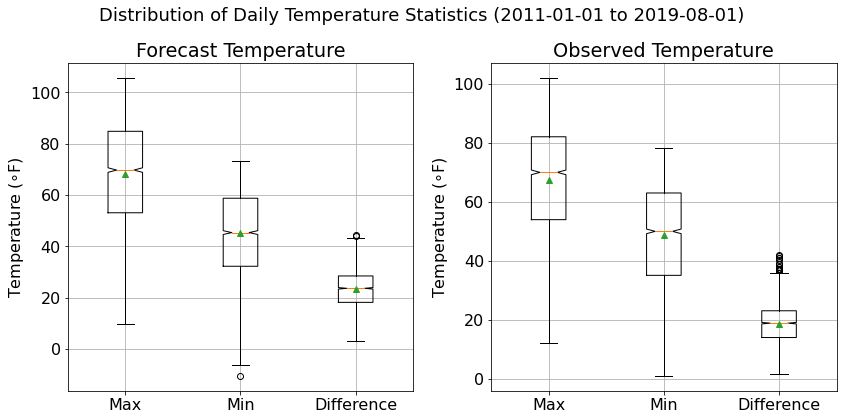

In [9]:
fs=16 #set font size to 16
matplotlib.rcParams.update({'font.size': fs}) #This sets a minimum fontsize for all matplotlib text (e.g. axis labels, tick labels, etc.)

#Initialize figure
fig = plt.figure(figsize=(12,6)) #This defines the dimension of the figure (17 in wide and 7 in tall)
#get axes of subplot instance (to add ticklabels, etc.) 
ax1 = plt.subplot(121)
#Plot distribution of GFS (00Z) forecast daily high/low temperature and temperature range
plt.boxplot([max_temperature_mdl,min_temperature_mdl,max_temperature_mdl-min_temperature_mdl],notch=True,showmeans=True,showfliers=True)
plt.grid(True) #Add grid to plot
#Add axis labels and title
plt.ylabel('Temperature ($\circ$F)')
ax1.set_xticklabels(['Max','Min','Difference'])
plt.title('Forecast Temperature')
#get axes of subplot instance (to add ticklabels, etc.) 
ax2 = plt.subplot(122)
#Plot distribution of observed daily high/low temperature and temperature range
plt.boxplot([max_temperature_obs,min_temperature_obs,max_temperature_obs-min_temperature_obs],notch=True,showmeans=True,showfliers=True)
plt.grid(True) #Add grid to plot
#Add axis labels and title
plt.ylabel('Temperature ($\circ$F)')
ax2.set_xticklabels(['Max','Min','Difference'])
plt.title('Observed Temperature')
#Tighten plot to remove extra whitespace
plt.tight_layout()
#Adjust plot to add space for sup title (figure title)
plt.subplots_adjust(top=0.85)
plt.suptitle('Distribution of Daily Temperature Statistics ('+dates[0]+' to '+dates[-1]+')',fontsize=fs+2)
#Display plot
plt.show()

### Baseline Model

At a minimum machine learning models should outperform NWP in forecasting the observed daily high/low temperature. 

Lets evaluate the accuracy of NWP by computing the error of the NWP model average for each target variable.

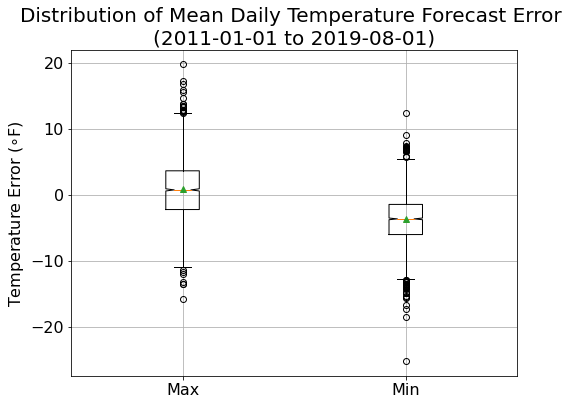

In [10]:
#Set minimum font size for plot
fs=16
matplotlib.rcParams.update({'font.size': fs})

#Plot NWP model mean errors statistic for min/max temperature, max wind speed, and precipitation
fig = plt.figure(figsize=(8,6))

#Plot min/max temperature error
ax1 = plt.subplot(111)
#Boxplots of daily temperature error (min/max)
plt.boxplot([max_temperature_mdl-max_temperature_obs,(min_temperature_mdl-min_temperature_obs)],notch=True,showmeans=True) #,whis=[5,95],showfliers=False)
plt.grid(True)
#Add axis and ticklabels
plt.ylabel('Temperature Error ($\circ$F)')
ax1.set_xticklabels(['Max','Min','Difference'])
plt.grid(True)
plt.title('Distribution of Mean Daily Temperature Forecast Error \n('+dates[0]+' to '+dates[-1]+')',fontsize=fs+4)
plt.show()

# **5. Data Pre-processing**

## Partitioning Data

To facillitate machine learning we need to split our dataset into two segments consisting of forecast data (features) and observation data (targets).

In ML variables used for prediction are called *features*. Conversely, *targets* are variables we seek to predict.

In [11]:
#Extract target (observation) data from dataset.
total_target_data = total_dataset.filter(like='OBS_tmpf') #Use pandas to filter and display temperature observation data in tabular format
print(total_target_data)

      OBS_tmpf_max  OBS_tmpf_min
0            53.96         35.06
1            53.60         30.02
2            41.00         24.08
3            48.02         24.08
4            42.98         30.92
...            ...           ...
3131         89.10         64.90
3132         90.00         68.00
3133         91.00         69.10
3134         87.10         68.00
3135         88.00         66.20

[3136 rows x 2 columns]


In [13]:
#Extract features (forecast) data from dataset 
dropCols = list(total_target_data.columns) + ['OBS_sknt_max','OBS_phour'] #Get list of variables in target dataset (add other obs variables not used in this module)
total_feature_data = total_dataset.copy(deep=True) #Copy full dataset to initalize feature dataset
total_feature_data = total_feature_data.drop(dropCols,axis=1) #Drop target variables (and date column) from feature dataset
#Display the feature dataset (contains no observations)
print(total_feature_data)

      index        date  ...  GFS18_sleet_rate_min  GFS18_sleet_rate_avg
0         0  2011-01-01  ...                   0.0                   0.0
1         1  2011-01-02  ...                   0.0                   0.0
2         2  2011-01-03  ...                   0.0                   0.0
3         3  2011-01-04  ...                   0.0                   0.0
4         4  2011-01-05  ...                   0.0                   0.0
...     ...         ...  ...                   ...                   ...
3131   3132  2019-07-28  ...                   0.0                   0.0
3132   3133  2019-07-29  ...                   0.0                   0.0
3133   3134  2019-07-30  ...                   0.0                   0.0
3134   3135  2019-07-31  ...                   0.0                   0.0
3135   3136  2019-08-01  ...                   0.0                   0.0

[3136 rows x 836 columns]


### How much data should go in each subset?
  - Depends (I know, not the most ideal answer)
  - Typical train/test split is 80% for training and 20% for testing
    - Varies for the size of your dataset

### **Lets split the data officially into training and testing datasets** 
  - Eliminate features with zero variance. (i.e. [variance thresholding](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.VarianceThreshold.html#sklearn.feature_selection.VarianceThreshold))

In [14]:
# Define Function to split data based on given dates
def split_data_year(feature_data,target_data,start_date,end_date):
  '''
  Args:
    feature_data (pandas.DataFrame): dataset containing features (i.e. forecast data)
    target_data (pandas.DataFrame): dataset containing targets (i.e. observations)
    start_date_str (str): start date, of ouput datasets, in format '%Y%m%d_%H%M'
    end_date (str): end date, of output datsets, in format: %Y%m%d_%H%M'

  Return: a pair of pandas.DataFrames containing data within a given date range
  '''

  data = feature_data.copy() #Copy the feature dataset (we want a new dataset - not linked in-memory to input dataset) 
  date_list = pd.to_datetime(data['date']) #Convert dates from string objects to datetime objects
  date_mask = (date_list >= start_date) & (date_list <= end_date) #Get list of indices with dates within the given date range
  out_features = data.loc[date_mask,:].drop(['date'],axis=1) #Extract feature dataset at indices within the date range.
  if (len(target_data.shape)>1):
    out_targets = target_data.loc[date_mask,:] #Extract target dataset at indices within the date range.
  else:
    out_targets = target_data.loc[date_mask] #Extract target dataset at indices within the date range.

  #Return feature and target datasets that containing data between the start and end date.
  return out_features,out_targets

# Define function to remove variables (features) with zero variance.
def drop_novar(Xs_train,Xs_test,ys_train):
  '''
  Args:
    Xs_train (pandas.DataFrame):  feature dataset used in training
    Xs_test (pandas.DataFrame):  feature dataset used in testing
    ys_train (pandas.DataFrame): target dataset used in training 
    
  Returns: a pair of pandas.DataFrames containing variables with nonzero variance
  '''

  #Select features whose variance is nill (e.g. columns with all zeros)
  vt_sel = VarianceThreshold(threshold=0).fit(Xs_train)
  #Transform training and testing feature datasets using variance threshold 
  #(transformed from a DataFrame to a multi-dimensional numpy array)
  Xs_train_vsel_arr = vt_sel.transform(Xs_train)
  Xs_test_vsel_arr = vt_sel.transform(Xs_test)

  #Get mask of features with zero variance
  fselect = vt_sel.get_support()
  
  #Retrieve column names of features with nonzero variance
  fidx = np.argwhere(fselect==1).T[0]
  #Identify names of good features
  good_features = Xs_train.columns[fidx]

  #Rebuild pandas dataframe 
  Xs_train_vsel = pd.DataFrame(Xs_train_vsel_arr, columns = good_features)
  Xs_test_vsel = pd.DataFrame(Xs_test_vsel_arr, columns = good_features)

  return Xs_train_vsel,Xs_test_vsel

In [15]:
#Split total datasets into two segements (Training: 2011 - 2017;  Testing: 2018-2019)
print(f"total_feature_data shape: {total_feature_data.shape}")
#Extract Training data between 2011 and 2017
X_train, y_train = split_data_year(total_feature_data,
    total_target_data,'2011-01-01','2017-12-31')

#Extract Testing data between 2018 and 2019
X_test, y_test = split_data_year(total_feature_data,
    total_target_data,'2018-01-01','2019-12-31')

#Remove variables (features) with zero variance, during the training period (2011-2017)
X_train,X_test = drop_novar(X_train,X_test,y_train)
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")

total_feature_data shape: (3136, 836)
X_train shape: (2555, 601)
X_test shape: (581, 601)


## Scaling and Transforming Data

 
Why should you scale your data?
- Some ML models are not scale invariant (e.g. [SVMs](https://scikit-learn.org/stable/modules/svm.html#regression) and [MLPs](https://scikit-learn.org/stable/modules/neural_networks_supervised.html#multi-layer-perceptron)). For these models, data variables with different scales (e.g. temperature versus sea-level pressure) affects what variables are considered important 
- Temperatures varying from $\sim$180-330 K will be prioritized over specific humidity values varying from $\sim$0-0.02 kg kg$^{-1}$

Normalizing or scaling data removes this issue.

**Important: We normalize/scale our data based on the training data and save these values to apply to testing data**

More details about each transformation method can be found [here](https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html#sphx-glr-auto-examples-preprocessing-plot-all-scaling-py)

**[MinMaxScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html)**

Scalar = $\frac{x_{i} - min(x)}{max(x) - min(x)}$

Scales data between 0 and 1 based on training data minimum and maximum values

**Method of scaling for this notebook**

- Replace any outlier values ( > 3 standard deviations from mean) with the training data mean

- Use MinMaxScaler after replacement

- Reduces the chance outliers affect training scaling values

In [16]:
# Define function to remove feature outliers that exceed three standard deviations
# of the feature mean during the training period.
def remove_outliers(train_features,test_features):
  '''
  Args:
    train_features (pandas.DataFrame):  feature dataset used in training
    test_features (pandas.DataFrame):  feature dataset used in testing
    
  Returns: a pair of pandas.DataFrames with outliers removed. Note that the threshold for outlier detection is defined from the TRAINING data!
  '''
  #Make copy of features prior to normalization and scaling
  no_outlier_train_features = train_features.copy()
  no_outlier_test_features = test_features.copy()

  #Retrieve the mean and standard deviation of features during training
  train_standard_dev = train_features.std()
  train_mean = train_features.mean()

  #Remove outliers from the training and testing datasets
  for column in train_features.columns:
    outlier_threshold_value = 3.0*train_standard_dev[column]
    
    #Where cond is True, keep the original value. Where False, replace with corresponding value from other
    no_outlier_train_features[column].where(
        np.abs(train_features[column]-train_mean[column]) < outlier_threshold_value, 
        train_mean[column],
        inplace=True) #Replace outliers (where feature is more than 3STDEV from training mean) with the mean value during training.

    no_outlier_test_features[column].where(
        np.abs(test_features[column]-train_mean[column]) < outlier_threshold_value, 
        train_mean[column],
        inplace=True) #Replace outliers (where feature is more than 3STDEV from training mean) with the mean value during training.
    
    #Return the traininga and testing DataFrames with outliers replaced.
    return no_outlier_train_features,no_outlier_test_features

# Define function to scale features to values between 0 and 1 (for SVM)
# using the min/max values of features during the training period.
def scale_data(train_features,test_features):
  '''
  Args:
    train_features (pandas.DataFrame):  feature dataset used in training
    test_features (pandas.DataFrame):  feature dataset used in testing
    
  Returns: a pair of pandas.DataFrames with features scaled to values between 0 and 1.
   Note that the threshold for outlier detection is defined from the TRAINING data!
  '''
  #Initialize MinMax scaler to with training dataset
  minmax_scaler = MinMaxScaler().fit(train_features)
  #Scale datasets using MinMax scaling derived solely from the training dataset
  train_features_scaled = minmax_scaler.transform(train_features)
  test_features_scaled = minmax_scaler.transform(test_features)
  #Return scaled features as pandas dataframes
  train_features_scaled = pd.DataFrame(train_features_scaled,columns=train_features.columns)
  test_features_scaled = pd.DataFrame(test_features_scaled,columns=test_features.columns)
  return train_features_scaled,test_features_scaled

#Remove outliers from full dataset
X_train_nout,X_test_nout = remove_outliers(X_train,X_test)
#Scale data from full dataset
X_train_scaled,X_test_scaled = scale_data(X_train_nout,X_test_nout)
print(f"X_train_scaled (no outliers) shape: {X_train_scaled.shape}")

X_train_scaled (no outliers) shape: (2555, 601)


## Dimensionality Reduction

Feature selection is about pairing down the number of features used in training to only those which help constrain model predictions.

If your background is in atmospheric science you could probably do this feature selection subjectively using prior knowledge. However, with ~1000 features in the dataset its much more efficient to utilize pre-existing approaches to feature selection that can help automate the process.

**Why perform dimensionality reduction?**
- Requires less space to store data
- Model training is faster on smaller dimensional datasets
- Only train on relevant features (reduces redundancy)
- Easier to visualize in lower dimensional space

**[Univariate Feature Selection](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html#sklearn.feature_selection.SelectKBest)**

Another approach to feature selection is to selet features based on univariate statistical tests. 

In [17]:
def get_usel(Xs_train,Xs_test,yval,cnt):
  '''
  Args:
    Xs_train (pandas.DataFrame):  feature dataset used in training
    Xs_test (pandas.DataFrame):  feature dataset used in testing
    
  Returns: a pair of pandas.DataFrames with univariate features selected. Note that the feature selected is performed using TRAINING data!
  '''
  #Select the highest 50 scoring features. Important! Only fit on the training dataset.
  ut_sel = SelectKBest(f_regression,k=cnt).fit(Xs_train,yval)
  #Transform both training and test datasets
  Xs_train_usel_arr = ut_sel.transform(Xs_train)
  Xs_test_usel_arr = ut_sel.transform(Xs_test)

  #Get mask of features selected
  fselect = ut_sel.get_support()
  #Retrieve and print column names of selected features
  fidx = np.argwhere(fselect==1).T[0]
  good_features = Xs_train.columns[fidx]

  #Convert to pandas dataframe
  Xs_train_usel = pd.DataFrame(Xs_train_usel_arr, columns = good_features)
  Xs_test_usel = pd.DataFrame(Xs_test_usel_arr, columns = good_features)

  #Show data dimensions before and after feature selection
  print(f'\nTraining Data shape: {Xs_train.shape}')
  print(f'Univariate Selected Training Data shape: {Xs_train_usel.shape}')
  return Xs_train_usel,Xs_test_usel

**[Model-based Feature Selection](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectFromModel.html#sklearn.feature_selection.SelectFromModel)**

Model-based estimators can be used to winnow features based on relative importance

In [18]:
# Define function to select a subset features based on their relative importance
# to a given scikit-learn model's predictions.
def get_msel(mdl,Xs_train,Xs_test,yval,thresh):
  '''
  Args:
    mdl (sklearn.model): Regression model from scikit-learn
    Xs_train (pandas.DataFrame):  feature dataset used in training
    Xs_test (pandas.DataFrame):  feature dataset used in testing
    
  Returns: a pair of pandas.DataFrames with a subset of features selected using tree-based learning.
  Note that feature selection is performed using TRAINING data!
  '''
  mdl.fit(Xs_train,yval)
  #Use select from model to discard irrelevant features
  model = SelectFromModel(mdl, threshold=thresh, prefit=True)
  #Transform both training and testing datasets
  Xs_train_tsel_arr = model.transform(Xs_train)
  Xs_test_tsel_arr = model.transform(Xs_test)
  #Retrieve indices of selected columns
  msel = model.get_support()
  #Get names of select features
  good_features = Xs_train.columns[msel]
  #Convert to pandas dataframe
  Xs_train_tsel = pd.DataFrame(Xs_train_tsel_arr, columns = good_features)
  Xs_test_tsel = pd.DataFrame(Xs_test_tsel_arr, columns = good_features)
  #Show data dimensions before and after feature selection
  print(f'\nTraining Data shape: {Xs_train.shape}')
  print(f'Tree-based Selected Training Data shape: {Xs_train_tsel.shape}')
  return Xs_train_tsel,Xs_test_tsel

Perform dimensionality reduction using the univariate selection and tree-based selection methods defined above.

In [ ]:
#Use univariate selection to find features linearly correlated with the target
X_train_usel,X_test_usel = get_usel(X_train_scaled,X_test_scaled,y_train['OBS_tmpf_max'].values,100)
print(f"X_train_usel shape: {X_train_usel.shape}")

#Use gradient boosting to perform model-based feature selection.
#Select features whose relative importances exceed the median (i.e. the most important half of the features)
xgb_mdl = xgb.XGBRegressor(n_estimators=250,objective='reg:squarederror',random_state=0) #Initialize gradient boosting model
X_train_tsel,X_test_tsel = get_msel(xgb_mdl,X_train,X_test,y_train['OBS_tmpf_max'].values,'median') #Perform feature selection
print(f"X_train_tsel shape: {X_train_tsel.shape}")

## Feature Analysis

### Univariate Feature Selection

Features are highly correlated since target variable (temperature) is present among features. 



In [ ]:
#Univariate Feature Selection
corr = X_train_usel.iloc[:,0:10].corr()
corr.style.background_gradient(cmap='coolwarm',vmin=-1,vmax=1).set_precision(2)

### Tree-based Feature Selection

Model-based feature selection results in a subset of features that exhibits less colinearity. A high degree of colinearity between trees can complicate efforts to assess feature importance, particularly in random forests.

In this notebook, ensemble methods generally perform best when tree-based feature selection is employed. In contrast, linear methods such as the SVM model and Linear Regression model worked best when trained using features retrieved through univariate feature selection.

In [ ]:
#Tree-based Feature Selection
corr = X_train_tsel.iloc[:,0:10].corr()
corr.style.background_gradient(cmap='coolwarm',vmin=-1,vmax=1).set_precision(2)

# **6. [Machine Learning (ML) Models](https://scikit-learn.org/stable/supervised_learning.html)**

### [Regression Scoring Metrics](https://scikit-learn.org/stable/modules/model_evaluation.html#regression-metrics))

Some common evaluation metrics used with regression problems are: 

Mean absolute error (MAE): $\frac{1}{N} \sum\limits_{i = 1}^{N} \lvert \hat{y}_i - y_i \rvert$

Mean squared error (MSE): $\frac{1}{N} \sum\limits_{i = 1}^{N} (\hat{y}_i - y_i)^2$

$R^2$ Score: $1 - \frac{\sum\limits_{i = 1}^{N}(\hat{y}_i - y_i)^2}{\sum\limits_{i = 1}^{N}(y_i - \bar{y_i})^2}$

where $\hat{y}_i$ is the observed value and ${y}_i$ is the predicted value.

More regression evalution metrics can be found [here](https://scikit-learn.org/stable/modules/model_evaluation.html#regression-metrics). 



In [ ]:
def regression_stats(name,ys_pred,ys_test):
  '''
  Args:
    name (str): Name of model
    ys_pred (numpy.array):  predicted maximum temperature
    ys_test (numpy.array):  observed maximum temperature
    
  Returns (None)
  '''
  #Calculate and display model error
  print('\n'+name)
  print(f'Score : {r2_score(ys_pred,ys_test)}')
  print(f'MAE: {mean_absolute_error(ys_pred,ys_test)}')
  print(f'RMSE : {np.sqrt(mean_squared_error(ys_pred,ys_test))}')

### [Linear Regression (LR)](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression)

LR fits a linear model to minimize the residual sum of squared between features in the dataset (X) and targets predicted by linear approximation (y). 

  - *Advantages*
    - Simple and fast to implement
    - Easy to interpret (less complexity)
  - *Disadvantages* 
    - The accuracy of the model is very sensitive to outliers
    - Can be overly simplistic
    - Performs poorly when relationships between variables are non-linear



In [ ]:
#Define function to build a linear regression model to predict max temperature
def run_lr(Xs_train,Xs_test,ys_train,ys_test,typ):
  '''
  Args:
    Xs_train (pandas.DataFrame): training dataset 
    Xs_test (pandas.DataFrame): testing dataset
    ys_train (numpy.array):  observed maximum temperature during training
    ys_test (numpy.array):  observed maximum temperature during testing
    typ (str): experiment name
    
  Returns:
    y_pred (numpy.array): predicted maximum temperature during testing
  '''
  #Initialize the model
  mLR = LinearRegression()
  #Train a multivariate linear regression (MLR) model
  mLR.fit(Xs_train,ys_train)
  #Generate predictions using test dataset
  y_pred = mLR.predict(Xs_test)
  #Calculate and display model error
  regression_stats('Linear Regression ('+typ+')',y_pred,ys_test)
  #print('Linear Regression (LR): '+str(round(np.sqrt(mean_squared_error(y_pred,y_test)),3))+' K')
  return y_pred

In [ ]:
# Print out error statistics for the NWP model (average of GFS00Z and GFS12Z)
y_true = y_test['OBS_tmpf_max'].values
y_mdl = max_temperature_mdl[-y_test.shape[0]:].values

print(f'NWP Score : {r2_score(y_mdl,y_true)}')
print(f'NWP MAE: {mean_absolute_error(y_mdl,y_true)}')
print(f'NWP RMSE : {np.sqrt(mean_squared_error(y_mdl,y_true))}')

In [ ]:
#Perform LR on full dataset
y_lr = run_lr(X_train,X_test,y_train['OBS_tmpf_max'].values,y_test['OBS_tmpf_max'].values,'All Features')

In [ ]:
#Perform LR on the reduced (tree-based selected) dataset
y_lr_tsel = run_lr(X_train_tsel,X_test_tsel,y_train['OBS_tmpf_max'].values,y_test['OBS_tmpf_max'].values,'Tree-based Select')

In [ ]:
#Perform LR on the reduced (univariate selected) dataset
y_lr_usel = run_lr(X_train_usel,X_test_usel,y_train['OBS_tmpf_max'].values,y_test['OBS_tmpf_max'].values,'Univariate Select')

### [Support Vector Machines (SVM)](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVR.html)

  - *Advantages*
    - Good at tackling problems in high dimensional spaces
    - Effective even when then number of features exceeds the number of samples

  - *Disadvantages*
    - Prone to over-fitting, especially when the number of features is much greater than the number of samples
    - Requires feature scaling

Examples in Atmospheric Science:
  - Temperature forecasting: [Radhika and Shashi 2009](https://doi.org/10.7763/IJCTE.2009.V1.9)
  - Tornado prediction ([Trafalis et al. 2003](https://link.springer.com/content/pdf/10.1007/3-540-44864-0_30.pdf); [Adrianto et al. 2009](https://doi.org/10.1080/03081070601068629))

In [ ]:
#Define function to build a linear SVM to predict max temperature
def run_svm(Xs_train,Xs_test,ys_train,ys_test,typ):
  '''
  Args:
    Xs_train (pandas.DataFrame): training dataset 
    Xs_test (pandas.DataFrame): testing dataset
    ys_train (numpy.array):  observed maximum temperature during training
    ys_test (numpy.array):  observed maximum temperature during testing
    typ (str): experiment name
    
  Returns:
    y_pred (numpy.array): predicted maximum temperature during testing
  '''
  svm_regr = svm.LinearSVR(random_state=0) #Note linear SVM!
  ##Note SVMs are not scale invariant so its recommended to first scale your data! 
  svm_regr.fit(Xs_train,ys_train)
  y_pred = svm_regr.predict(Xs_test)
  #Calculate and display model error
  regression_stats('Support Vector Machine ('+typ+')',y_pred,ys_test)
  return y_pred

In [ ]:
#SVM trained on full dataset
y_svm = run_svm(X_train,X_test,y_train['OBS_tmpf_max'].values,y_test['OBS_tmpf_max'].values,'All Features')

In [ ]:
#SVM with univariate feature seletion (univariate feature were pre-scaled - see Linear Regression cell above)
y_svm_usel = run_svm(X_train_usel,X_test_usel,y_train['OBS_tmpf_max'].values,y_test['OBS_tmpf_max'].values,'Univariate Select')

## [Ensemble Methods](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.ensemble)



### [Gradient Boosting (GB)](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.HistGradientBoostingRegressor.html#sklearn.ensemble.HistGradientBoostingRegressor)
- *Advantages*: 
  - Fast!
  - Uses sequantial learning (boosting) to reduce both variance and bias.  
  - With hyper-parameter tuning can outperform random forests and other ensemble decision tree algorithms.
  - Many supported algorithms (e.g. [XGBoost](https://xgboost.readthedocs.io/en/latest/), [GradientBoosting](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html), [HistGradientBoosting](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.HistGradientBoostingRegressor.html#sklearn.ensemble.HistGradientBoostingRegressor))
- *Disadvantages*
  - Harder to interpret than other tree-based models. 
  - Can be harder to tune hyper-parameters compared to random forests.

More info about *HistGradientBoosting* [here](https://machinelearningmastery.com/histogram-based-gradient-boosting-ensembles/). 

Examples in Atmospheric Science
  - Severe storm classification: ([Haberlie and Ashley, 2018](https://doi.org/10.1175/JAMC-D-17-0293.1); [Jergensen et al., 2020](https://doi.org/10.1175/WAF-D-19-0170.1))
  - Satellite meteorology ([Kilpatrick et al. 2019](https://doi.org/10.1175/JTECH-D-18-0103.1); [Ma et al., 2018](https://doi.org/10.1175/JHM-D-17-0109.1))
  - Wind forecasting: ([Sprenger et al., 2017](https://doi.org/10.1175/WAF-D-16-0208.1))
  - Probablistic forecasting of severe weather ([Simon et al., 2018](https://doi.org/10.1175/MWR-D-17-0366.1))
  - Bias correction of anonymous smartphone pressure observations ([McNicholas and Mass, 2021](https://doi.org/10.1175/WAF-D-20-0222.1))

In [ ]:
#Define function to build a gradient boosting model to predict max temperature
def run_gb(Xs_train,Xs_test,ys_train,ys_test,typ):
  '''
  Args:
    Xs_train (pandas.DataFrame): training dataset 
    Xs_test (pandas.DataFrame): testing dataset
    ys_train (numpy.array):  observed maximum temperature during training
    ys_test (numpy.array):  observed maximum temperature during testing
    typ (str): experiment name
    
  Returns:
    y_pred (numpy.array): predicted maximum temperature during testing
  '''
  # Perform boosting with 250 trees (using Xtreme Gradient Boosting - XGB)
  xgb_regr = xgb.XGBRegressor(n_estimators=250,objective='reg:squarederror',random_state=0)
  #Fit XGB Regressor to training data
  xgb_regr.fit(Xs_train,ys_train)
  #Make predictions using test features
  y_pred = xgb_regr.predict(Xs_test)
  #Calculate and display model error
  regression_stats('Gradient Boosting ('+typ+')',y_pred,ys_test)
  return y_pred

In [ ]:
#Perform Gradient Boosting with XGB
y_xgb = run_gb(X_train,X_test,y_train['OBS_tmpf_max'].values,y_test['OBS_tmpf_max'].values,'All Features')

In [ ]:
#Perform gradient boosting with select (tree-based) features
y_xgb_tsel = run_gb(X_train_tsel,X_test_tsel,y_train['OBS_tmpf_max'].values,y_test['OBS_tmpf_max'].values,'Tree-based Select')

In [ ]:
#Perform gradient boosting with select (univariate) features
y_xgb_usel = run_gb(X_train_usel,X_test_usel,y_train['OBS_tmpf_max'].values,y_test['OBS_tmpf_max'].values,'Univariate Select')

### [Random Forests (RF)](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html)
- *Advantages*
  - Robust to oultiers and less likely to overfit than decision trees. 
  - Usually accurate out of the box without the need for much parameter tuning.
- *Disadvantages*
  - Slower than other ensemble decision tree algorithms. 
  - Requires a large number of samples for training.

Examples in Atmospheric Science
  -  Prediction of Aviation turbulence ([Williams, 2004](https://doi.org/10.1007/s10994-013-5346-7))
  -  Ensemble forecasting ([Loken et al., 2019](https://doi.org/10.1175/WAF-D-19-0109.1))
  -  Severe weather forecasting:
     - Tornadogenesis ([McGovern et al., 2014](https://doi.org/10.1007/s10994-013-5343-x))
     - Straight-line winds ([Lagerquist et al., 2017](https://doi.org/10.1175/WAF-D-18-0183.1))
     - Probablistic forecasting ([Hill et al., 2020](https://doi.org/10.1175/MWR-D-19-0344.1))
     - Dryline/MCS feature identification ([Clark et al., 2015](https://doi.org/10.1175/WAF-D-15-0070.1))
  - Smartphone pressure bias correction [(McNicholas and Mass, 2018)](https://journals.ametsoc.org/view/journals/atot/35/3/jtech-d-17-0096.1.xml)
  


In [ ]:
#Define function to build a random forest model to predict max temperature
def run_rf(Xs_train,Xs_test,ys_train,ys_test,typ):
  '''
  Args:
    Xs_train (pandas.DataFrame): training dataset 
    Xs_test (pandas.DataFrame): testing dataset
    ys_train (numpy.array):  observed maximum temperature during training
    ys_test (numpy.array):  observed maximum temperature during testing
    typ (str): experiment name
    
  Returns:
    y_pred (numpy.array): predicted maximum temperature during testing
  '''
  rf_regr = RandomForestRegressor(n_estimators=250,n_jobs=-1,random_state=0)
  #Fit Random Forest to training data
  rf_regr.fit(Xs_train,ys_train)
  #Produce predictions using test features
  y_pred = rf_regr.predict(Xs_test)
  #Calculate and display model error
  regression_stats('Random Forest ('+typ+')',y_pred,ys_test)
  return y_pred

In [ ]:
# Fit a random forest model using select (tree-based) features
y_rf_tsel = run_rf(X_train_tsel,X_test_tsel,y_train['OBS_tmpf_max'].values,y_test['OBS_tmpf_max'].values,'Full Dataset')

Compared to more sophisticated tree-based models like random forests and gradient boosting, good old linear regression performs remarkably well. Why do you think this is the case?

## Aggregate Methods

  - *Advantages*
    - Works well with models that have similar performance. 
    - Helps offset weakness of individual models 
    - Easily extendable.

  - *Disadvantages*
    - Simplistic. Averages individual preditions from each ML model. 

### [Voting Regressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingRegressor.html)

In [ ]:
#Define function to build a voting regressor to predict max temperature
#This model attempts to combine the best predictions of several models (e.g. LR, SV, and XGB)
def run_vote(Xs_train,Xs_test,ys_train,ys_test,typ):
  '''
  Args:
    Xs_train (pandas.DataFrame): training dataset 
    Xs_test (pandas.DataFrame): testing dataset
    ys_train (numpy.array):  observed maximum temperature during training
    ys_test (numpy.array):  observed maximum temperature during testing
    typ (str): experiment name
    
  Returns:
    y_pred (numpy.array): predicted maximum temperature during testing
  '''
  #Initialize models
  mlr_reg = LinearRegression() #Linear Regression
  svm_reg = svm.LinearSVR(random_state=0) #Linear SVM
  xgb_regr = xgb.XGBRegressor(n_estimators=250,objective='reg:squarederror',random_state=0)
  comb = VotingRegressor([('lr', mlr_reg), ('svm', svm_reg), ('xgb', xgb_regr)]) #Combine models with Voting Regressor
  comb.fit(Xs_train,ys_train) #Fit voting regressor
  #Generate predictions for test dataset
  y_pred = comb.predict(Xs_test)
  #Calculate and display model error
  regression_stats('Voting Regressor ('+typ+')',y_pred,ys_test)
  return y_pred

In [ ]:
#Scale features from tree-based selection (for use in SVM)
X_train_tsel_scaled,X_test_tsel_scaled = scale_data(X_train_tsel,X_test_tsel)

#Use XGBTree-based feature selection to select features contributing the most to target prediction
y_vote_tsel = run_vote(X_train_tsel_scaled,X_test_tsel_scaled,y_train['OBS_tmpf_max'].values,y_test['OBS_tmpf_max'].values,'Tree-based Select')

### [Stacking Regressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingRegressor.html#sklearn.ensemble.StackingRegressor)


In [ ]:
#Define function to build a stacked regression model to predict max temperature
#This model stacks various ML models (e.g. SVM and XGB) to sequentially improve predictions 
def run_stack(Xs_train,Xs_test,ys_train,ys_test,typ):
  '''
  Args:
    Xs_train (pandas.DataFrame): training dataset 
    Xs_test (pandas.DataFrame): testing dataset
    ys_train (numpy.array):  observed maximum temperature during training
    ys_test (numpy.array):  observed maximum temperature during testing
    typ (str): experiment name
    
  Returns:
    y_pred (numpy.array): predicted maximum temperature during testing
  '''
  #Initialize the models
  mlr_reg = LinearRegression() #Linear Regression
  svm_reg = svm.LinearSVR(random_state=0) #Linear SVM
  xgb_regr = xgb.XGBRegressor(n_estimators=250,objective='reg:squarederror',random_state=0)
  comb_stack = StackingRegressor([('lr', mlr_reg), ('svm', svm_reg), ('xgb', xgb_regr)]) #Stack models
  comb_stack.fit(Xs_train,ys_train) #Fit stacked regressor
  #Generate predictions for test dataset
  y_pred = comb_stack.predict(Xs_test)
  #Calculate and display model error
  regression_stats('Stacking Regressor ('+typ+')',y_pred,ys_test)
  return y_pred

In [ ]:
#Use scaled tree-based selected features to train a sequential (stacking) regressor
#Note: Always test whether scaling/outlier removal actually benefits predictions!
y_stack_tsel = run_stack(X_train_tsel_scaled,X_test_tsel_scaled,y_train['OBS_tmpf_max'].values,y_test['OBS_tmpf_max'].values,'Tree-based Select')

# **7. Model Evaluation**

## Model Comparison


Below we compare the performance of machine learning models trained above to the NWP forecast model average.

Since ML models are primarily trained with mean squared error (MSE) loss as a scoring metric we'll examine the MSE of all models

We'll also explore how the accuracy of ML predictions compares to the NWP model average as a function of error magnitude (i.e. percentile). 

In [ ]:
def compute_err(ys_pred,ys_test):
  '''
  Args:
    ys_pred (numpy.array):  predicted maximum temperature during testing
    ys_test (numpy.array):  observed maximum temperature during testing
    
  Returns:
    y_err (numpy.array): difference between model prediction and observation
  '''
  #Return the error (difference between prediction and observation during the testing period)
  yerr = ys_pred - ys_test
  return yerr

def compute_pct_err(ys_pred,ys_test,ys_nwp):
  '''
  Args:
    ys_pred (numpy.array):  predicted maximum temperature during testing
    ys_test (numpy.array):  observed maximum temperature during testing
    
  Returns:
    parr (numpy.array): difference in the cumulative distribution of error between an NWP model and an ML model 
  '''
  parr = []
  for k in range(2,101,1):
    parr.append(np.percentile(abs(ys_pred-ys_test),k)-np.percentile(abs(ys_nwp-ys_test),k))

  parr = np.array(parr)
  return parr

y_test_tmp = y_test['OBS_tmpf_max'].values

yerr_lr = compute_err(y_lr_tsel,y_test_tmp)
yerr_svm = compute_err(y_svm_usel,y_test_tmp)
yerr_rf = compute_err(y_rf_tsel,y_test_tmp)
yerr_xgb = compute_err(y_xgb_tsel,y_test_tmp)
yerr_vote = compute_err(y_vote_tsel,y_test_tmp)
yerr_stack = compute_err(y_stack_tsel,y_test_tmp)

#Set minimum font size for plot
fs=16
matplotlib.rcParams.update({'font.size': fs})

nwp_max_tmp = max_temperature_mdl[-y_test_tmp.shape[0]:].values
nwp_err = nwp_max_tmp - y_test_tmp

lr_err_diff = compute_pct_err(y_lr_tsel,y_test_tmp,nwp_max_tmp)
svm_err_diff = compute_pct_err(y_svm_usel,y_test_tmp,nwp_max_tmp)
rf_err_diff = compute_pct_err(y_rf_tsel,y_test_tmp,nwp_max_tmp)
xgb_err_diff = compute_pct_err(y_xgb_tsel,y_test_tmp,nwp_max_tmp)
vote_err_diff = compute_pct_err(y_vote_tsel,y_test_tmp,nwp_max_tmp)
stack_err_diff = compute_pct_err(y_stack_tsel,y_test_tmp,nwp_max_tmp)

fig = plt.figure(figsize=(20,8))
ax1 = plt.subplot(121)
plt.boxplot([nwp_err**2,yerr_svm**2,yerr_rf**2,yerr_lr**2,yerr_xgb**2,yerr_vote**2,yerr_stack**2],notch=True,showmeans=True,showfliers=False)
plt.grid(True)
plt.axhline(y=np.median(nwp_err**2),color='k',linestyle='--',lw=2,alpha=0.5) #np.median(yerr_lr),color='k',linestyle='--',lw=2,alpha=0.5)
#plt.ylim([0,30])
plt.ylabel('Temperature Error ($\circ$F)')
ax1.set_xticklabels(['NWP','SVM','RF','LR','XBG','Vote','Stack'])
plt.title('Mean Squared Error (MSE)')
ax2 = plt.subplot(122)
pct_ran = np.arange(2,101,1)
#plt.plot(pct_ran,lr_err_diff,color='k',label='LR')
plt.plot(pct_ran[::4],svm_err_diff[::4],'-ok',color='orangered',ms=7,label='SVM')
plt.plot(pct_ran[::4],rf_err_diff[::4],'-ok',color='firebrick',label='RF',ms=7)
plt.plot(pct_ran[::4],lr_err_diff[::4],'-ok',ms=7,label='LR')
plt.plot(pct_ran[::4],xgb_err_diff[::4],'-ok',color='royalblue',label='XGB',ms=7)
plt.plot(pct_ran[::4],vote_err_diff[::4],'-ok',color='forestgreen',label='Vote',ms=7)
plt.plot(pct_ran[::4],stack_err_diff[::4],'-ok',color='hotpink',label='Stack',ms=7)
plt.legend(numpoints=1,loc='best')
plt.grid(True)
plt.axhline(y=0,color='k',linestyle='--',lw=2,alpha=0.5) #np.median(yerr_lr),color='k',linestyle='--',lw=2,alpha=0.5)
plt.ylabel('Temperature Error Difference ($\circ$F)')
plt.title('Cumulate Error Difference from NWP')
plt.xlabel('Percentile (%)')
#ax1.set_xticklabels(['DT','SVM','MLP','LR','XGB','RF','Vote','Stack'])
plt.suptitle('KROA | Daily Max Temperature Error ('+dates[0]+' to '+dates[-1]+')',fontsize=fs+4)
plt.show()

**All ML models outperform the NWP model average**.

*Mean Squared Error*

- The best model is actually a combination of models (i.e. the stacking regressor). The stacked regressor combines the linear regressor, SVM, and gradient boosting model into one. 

*Cumulative Error Difference*

- The difference in the distribution of error between the NWP model average and the ML models reveals **why machine learning is so powerful!**
- The efficacy of machine learning models in reducing error is felt most strongly at the tail of the max temperature error distribution. On any given day, with quiescent weather and low model error, ML models may offer only marginal benefit over the NWP model average (e.g. at 10th percentile). However, when NWP model errors are large at the tail of the distribution, that is when machine learning really shines!





## Learning Curves

**Can we do better?**

Machine learning performance is often examined in terms of bias and variance. Balancing the trade-off betweent the two is a key challenge for any ML model.

Learning curves provide a way to visualize this trade-off. Learning curves display training and testing (or cross-validation) error as a function of training sample size. 

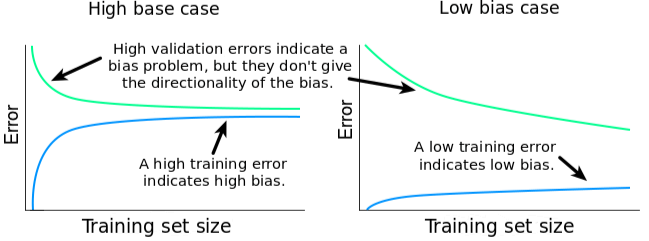

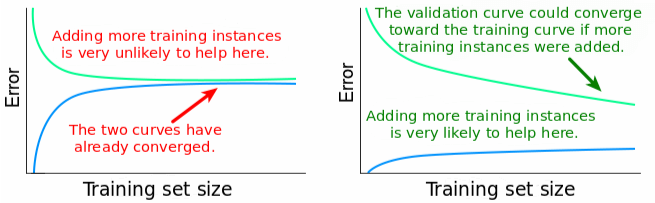

For further explanation of learning curves and the bias-variance trade-off see this [link](https://www.dataquest.io/blog/learning-curves-machine-learning/).

Ideally we'd like our learning curve to look something like this:

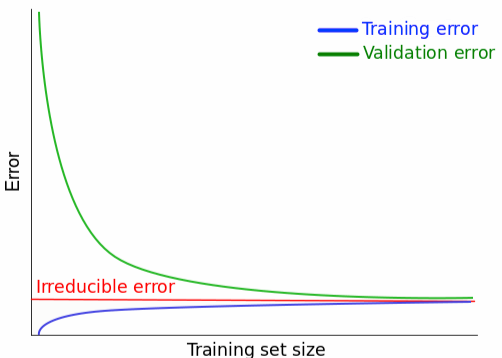

------------------------------------------------------------------------

Run the next two cells below to produce learning curves for the Max Temperature XGBRegressor. 

In [ ]:
from sklearn.model_selection import learning_curve
# Generate a plot depicting the test and training learning curve for a given 
# ML model (e.g. XGB)
def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
  
  """
  Parameters
  ----------
  estimator : estimator instance
      An estimator instance implementing `fit` and `predict` methods which
      will be cloned for each validation.

  title : str
      Title for the chart.

  X : array-like of shape (n_samples, n_features)
      Training vector, where ``n_samples`` is the number of samples and
      ``n_features`` is the number of features.

  y : array-like of shape (n_samples) or (n_samples, n_features)
      Target relative to ``X`` for classification or regression;
      None for unsupervised learning.

  axes : array-like of shape (3,), default=None
      Axes to use for plotting the curves.

  ylim : tuple of shape (2,), default=None
      Defines minimum and maximum y-values plotted, e.g. (ymin, ymax).

  cv : int, cross-validation generator or an iterable, default=None
      Determines the cross-validation splitting strategy.
      Possible inputs for cv are:

        - None, to use the default 5-fold cross-validation,
        - integer, to specify the number of folds.
        - :term:`CV splitter`,
        - An iterable yielding (train, test) splits as arrays of indices.

      For integer/None inputs, if ``y`` is binary or multiclass,
      :class:`StratifiedKFold` used. If the estimator is not a classifier
      or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

      Refer :ref:`User Guide <cross_validation>` for the various
      cross-validators that can be used here.

  n_jobs : int or None, default=None
      Number of jobs to run in parallel.
      ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
      ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
      for more details.

  train_sizes : array-like of shape (n_ticks,)
      Relative or absolute numbers of training examples that will be used to
      generate the learning curve. If the ``dtype`` is float, it is regarded
      as a fraction of the maximum size of the training set (that is
      determined by the selected validation method), i.e. it has to be within
      (0, 1]. Otherwise it is interpreted as absolute sizes of the training
      sets. Note that for classification the number of samples usually have
      to be big enough to contain at least one sample from each class.
      (default: np.linspace(0.1, 1.0, 5))
  """

  # Set plot title
  axes.set_title(title)
  # Set y-limit (if not None)
  if ylim is not None:
      axes.set_ylim(*ylim)
  # Add axis labels
  axes.set_xlabel("Training examples")
  axes.set_ylabel("Mean Squared Error")

  # Compute learning curves for the estimator (performs ML using training datasets
  # of varying size to determine the sensitivity of ML performance to dataset size)
  train_sizes, train_scores, test_scores, fit_times, _ = \
      learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                    train_sizes=train_sizes,scoring='neg_mean_squared_error',
                    return_times=True)
  
  # Compute the mean and standard deviation of training and testing scores
  train_scores_mean = np.mean(abs(train_scores), axis=1)
  train_scores_std = np.std(abs(train_scores), axis=1)
  test_scores_mean = np.mean(abs(test_scores), axis=1)
  test_scores_std = np.std(abs(test_scores), axis=1)

  # Plot training curve (training score - red)
  axes.fill_between(train_sizes, train_scores_mean - train_scores_std,
                      train_scores_mean + train_scores_std, alpha=0.1,
                      color="r")
  # Plot testing curve (cross validation score - green)
  axes.fill_between(train_sizes, test_scores_mean - test_scores_std,
                      test_scores_mean + test_scores_std, alpha=0.1,
                      color="g")
  # Plot mean of each curve
  axes.plot(train_sizes, train_scores_mean, 'o-', color="r",
              label="Training score")
  axes.plot(train_sizes, test_scores_mean, 'o-', color="g",
              label="Cross-validation score")
  # Add legend
  axes.legend(loc="best")

In [ ]:
# Initialize XGB model
xgb_reg = xgb.XGBRegressor(n_estimators=250,objective='reg:squarederror',random_state=0)

# Initialize the figure
fig = plt.figure(figsize=(12,8))
# Define an axis and subplot
ax1 = plt.subplot(111)
# Plot learning curves for an XGB model trained to predict max daily temperature
plot_learning_curve(xgb_reg,'XGB Learning Curves (Maximum Temperature)', X_train_tsel,y_train['OBS_tmpf_max'].values,ax1,n_jobs=-1)
# Add grid and tighten layout
ax1.grid(True)
plt.tight_layout()

The learning curves show low training error which indicates low bias.
The large gap between the testing error (green) and training error (red) indicates large variance. 

In our case the XGB model is likely over-fitting the training data. The model might benefit from:
  - Add more training data (This one is obvious!)
  - Feature engineering:
    - designing better features with less collinearity could improve testing error and increase training error
  - Target Modification
    - changing the target variable could help reduce collinearity between features but may require some feature engineering 
  - Reducing the complexity of the model  
     - Reducing the total number of features could increase the training error and bring it more in line with the testing error

--------------------------------------------------------------------------------

So, how do we try to tackle the gap between the training and testing data?

Since we don't have any additional data we can't add simply expand our training dataset. This leaves us with a few options:

*   Modify our features list
  * Try fewer features to reduce model complexity
  * Create new features (e.g. $ΔT$, Day of Year, etc.) that we think might help reduce prediction error
*   Redfine our target variable (i.e. what we want to predict)

Lets first try looking out what features are contributing most to our predictions. This should help us decide the best course of action.

In [ ]:
#Examine feature importance for the XGBoost regressor 
from sklearn.inspection import permutation_importance

#Define a function to retrieve feature importance from tree-based model
def run_gb_mdl(mdl,Xs_train,Xs_test,ys_train,ys_test,typ):
  mdl.fit(Xs_train,ys_train)
  feats = mdl.feature_importances_
  fidx = np.argsort(feats)[::-1]
  #Make predictions using test features
  y_pred = mdl.predict(Xs_test)
  #Calculate and display model error
  regression_stats(typ,y_pred,ys_test)
  #Return predictions, feature importance, and index of features sorted by importance
  return y_pred,feats[fidx],fidx

xgb_reg = xgb.XGBRegressor(n_estimators=250,objective='reg:squarederror',random_state=0)
y_xgb_tmax,y_xgb_feat,y_xgb_fidx = run_gb_mdl(xgb_reg,X_train_tsel,X_test_tsel,y_train['OBS_tmpf_max'].values,y_test['OBS_tmpf_max'].values,'XGboost (Tree-based Select)')

print('\nNWP (Model Averge)')
print(f'MAE: {mean_absolute_error(nwp_max_tmp,y_test["OBS_tmpf_max"].values)}')
print(f'RMSE: {np.sqrt(mean_squared_error(nwp_max_tmp,y_test["OBS_tmpf_max"].values))}')

Examine the feature importance below for the XGBoost model and consider the effects of colinearity (recall 5. Feature Analysis)

In [ ]:
# Plot the impurity-based feature importances of the forest 

#Display top 10 features
no_of_feats = 10

#Initialize figure
plt.figure(figsize=(10,6))
#Add title and axis labels
plt.title("XGB Feature importances (Top 10)")
plt.ylabel('Feature Importance (normalized)')
#Plot feature importance as bar chart
plt.bar(range(0,no_of_feats), y_xgb_feat[0:no_of_feats],
        color="royalblue", align="center")
#Add feature names below tick labels 
plt.xticks(range(0,no_of_feats), X_train_tsel.columns[y_xgb_fidx][0:no_of_feats],rotation=45)
plt.xlim([-1, no_of_feats]) #Set axis limits
plt.show()

# **8. Exercise**

In this exercise we'll explore try and predict minimum temperature using a variety of machine learning models. In doing so we'll seek answers to the following questions:

* Are ML models more accurate at predicting minimum or maximum temperature?
* Can adding features improve ML model performance?
* What happens if we predict temperature error instead of absolute temperature?

### 1. How do ML models perform when predicting minimum temperature?  

Before we dive in lets perform some dimensionality reduction. We need to repeat this process of feature selection since we'll be predicting a new variable: minimum temperature. 

In [ ]:
# To begin lets start out by performing feature selection with minimum temperature as our target

''' Copy the code from the code block above "Feature Analysis" and change the observation from OBS_tmpf_max to OBS_tmpf_min 
    Don't forget to print out the shape of the new X_train and X_test objects to see how many features have been selected '''


To answer the posed question lets perform some ML experiments predicting minimum temperature. Use the functions defined in the course, in section 6., to produce predictions of minimum temperature during the testing period.

An example of how to do this (with a linear regression model) is provided below for reference:

In [ ]:
# To begin here is an example of a linear regressor used to predict min temperature

# Print out min temperature forecast error statistics for the NWP model (average of GFS00Z and GFS12Z)
y_true = y_test['OBS_tmpf_min'].values
y_mdl = min_temperature_mdl[-y_test.shape[0]:].values

print(f'GFS Score : {r2_score(y_mdl,y_true)}')
print(f'GFS MAE: {mean_absolute_error(y_mdl,y_true)}')
print(f'GFS RMSE : {np.sqrt(mean_squared_error(y_mdl,y_true))}')

### Linear Regression ###
y_lr = run_lr(X_train,X_test,y_train['OBS_tmpf_min'].values,y_test['OBS_tmpf_min'].values,'All features')

''' Below add code to run a linear regression model with univariate features. Change the last argument of the 
    "run_lr" function to change the title of the score output. (e.g. "Univariate-Select" for univarate selection) '''

# LR with univariate selection

# LR with tree-based selection

In [ ]:
### XGB Model ###
''' Use the run_gb function to produce XGB minimum temperature predictions below 
    use the examples from section 6 as a guide. Experiment with using all features
    or just tree-based select features'''

# XGB with all features

# XGB with tree-based select features

In [ ]:
### Stacked Regressor ###
''' Use the stacked regressor to predict minimum temperature,
    combine a linear regression model with an XGB model. Use the example
    from section 6 as a guide. For this case, use tree-based features.
    You don't need to scale your data.'''
    
# Run stacked regressor using tree-based feature selection

Is the RMSE and MAE lower than that observed for maximum temperature (see section 6.)


### 2. Can adding features improve ensemble ML model prediction?


To answer this question we'll start by creating a new feature dataset. This feature dataset will contain the following new variables:
- The variance of each variable across model runs 
  - e.g. standard deviation of temperature forecasts
- The average difference, across model runs, for each variable 
  - e.g. average difference in temperature forecast between model runs

Run the following code block to create the new feature dataset.  


In [ ]:
### RUN THIS BLOCK - NO EDITS REQUIRED ###

# Split feature dataset by model run
gfs0 = total_feature_data.filter(like='GFS0')
gfs6 = total_feature_data.filter(like='GFS6')
gfs12 = total_feature_data.filter(like='GFS12')
gfs18 = total_feature_data.filter(like='GFS18')

# Define function to rename variables (place model run at end of variable)
# This will make computing things like STDEV of a variable across model
# runs alot easier!
def df_rename(dff,gname):
  for c in dff.columns:
    variable_name = c.split(gname)[-1][1:]
    dff.rename({c:variable_name+'_'+gname},axis=1,inplace=True)
  return dff

#Get list of model variables available for each model run
vnames = []
for c in gfs0.columns:
  vnames.append(c.split('GFS0')[-1][1:])
vnames = np.array(vnames)

# Rename variables for each model run
gfs_00 = df_rename(gfs0,'GFS0')
gfs_06 = df_rename(gfs6,'GFS6')
gfs_12 = df_rename(gfs12,'GFS12')
gfs_18 = df_rename(gfs18,'GFS18')

# Combine GFS runs into a single feature dataset
total_feature_all = pd.concat([gfs_00,gfs_06,gfs_12,gfs_18],axis=1)

# Compute the standard deviation and average dprog/dt for each GFS variable
for v in vnames:
  total_feature_all['std_'+v] = total_feature_all.filter(like=v).std(axis=1)
  total_feature_all['trend_'+v] = total_feature_all.filter(like=v).diff(axis=1).mean(axis=1)

# Add date variable to new feature dataset to facillitate train/test splitting
total_feature_all = pd.concat([total_feature_all,total_feature_data['date']],axis=1)

The above block created two new datasets: 
* total_target_all
* total_feature_all

These datasets represent new target and feature datasets that contain additional features that incorporate information about variable trends and standard deviations across model runs. 

Use these new datasets in the following code block to create new training and testing DataFrames.

In [ ]:
''' 
    Now that we've updated our target and feature datasets to include the model error data
    we need to split our newly created feature and target dataset. 

    Write code below to split total_feature_new and total_target_new into training and testing datasets. 
    Feel free to copy and modify the code from section 5. (partioning data) to accomplish this.
    Be sure to rename X_train and X_test if you do this! 
'''

#Split total datasets into two segements (Training: 2011 - 2017;  Testing: 2018-2019)

#Extract Training data between 2011 and 2017

#Extract Testing data between 2018 and 2019

#Remove variables (features) with zero variance, during the training period (2011-2017)


In [ ]:
# Run XGB model to predict 
''' Use the run_gb function to predict the minimum temperature using the original
    and new feature datasets. Compare the results.
    
    Refer to the examples from section 6 as a guide. Remember to use the training
    and testing datasets you created in the previous code block.
    '''

# Train and execute an XGB model using the original X_train and X_test datasets

# Train and execute an XGB model using the new X_train and X_test datasets
# that contain additional (derived) feature variables.


## 3. What happens if we predict temperature error instead of absolute temperature?

The final question in this exercise asks if predicting temperature error instead of absolute temperature could provide better results? Let's find out!

First let's compute the minimum temperature forecast error for each GFS run.

In [ ]:
### RUN THIS BLOCK - NO EDITS REQUIRED ###

# Get MOS error
mdl_err = total_feature_data.filter(like='tf').filter(like='min')-np.array([total_target_data['OBS_tmpf_min'].values]).T

# Define new target (model error))
for c in mdl_err.columns:
  mdl_err.rename({c:c+'_err'},axis=1,inplace=True)

# Compute the model average minimum temperature error 
total_err_mean = pd.Series(mdl_err.mean(axis=1).values,name='mean_error')

# Shift the model average error back by one index to get a data series containing the forecast
# error from the previous day
total_target_persist = total_err_mean.shift(periods=1)

# Create a new target dataset by adding the model average error to the 
# original target dataset containing OBS_tmpf_min and OBS_tmpf_max
total_target_new = pd.concat([total_target_data,total_err_mean],axis=1).iloc[1:]

# Add the persistance error (previous day's model error) to the feature dataset
total_feature_new = pd.concat([total_feature_data.copy(),total_target_persist],axis=1).iloc[1:]

# Rename mean error in feature dataset to persistance error (mean error from previous day)
total_feature_new = total_feature_new.rename({'mean_error':'persist_error'})

The above block created two new datasets: 
* total_target_new
* total_feature new

These datasets represent new target and feature datasets that contain additional information about model forecast error data. Use them in the following code block to create new training and testing DataFrames as outlined in Section 5.

In [ ]:
''' 
    Now that we've updated our target and feature datasets to include the model error data
    we need to split our newly created feature and target dataset. 

    Write code below to split total_feature_new and total_target_new into training and testing datasets. 
    Feel free to copy and modify the code from section 5. (partioning data) to accomplish this.
    Be sure to rename X_train and X_test if you do this! 
'''

#Split total datasets into two segements (Training: 2011 - 2017;  Testing: 2018-2019)


#Extract Training data between 2011 and 2017

#Extract Testing data between 2018 and 2019

#Remove variables (features) with zero variance, during the training period (2011-2017)


Now that we've split our new feature and target datasets into testing and training datasets lets train an XGB model to **predict the minimum temperature forecast error**

In [ ]:
# Run XGB model to predict model average temperature error
''' Use the run_gb function to predict minimum temperature forecast error.
    Refer to the examples from section 6 as a guide. Remember to use the training
    and testing datasets you created in the previous code block. Also, note that the
    new target is called: mean_error. So you should be trying to predict: y_test_err['mean_error'] 
    '''

By this point you should have trained and executed an XGB model to predict the model average temperature error (defined as: *mean_error* in the *total_target_dataset*). What sort of result did you get? 

Did you see better performance when you trained an XGB model to predict the minimum (absolute) temperature. Or did the model perform better when trained to predict the temperature *error*?

## **Bonus Exercise**

-- *For all you over achievers out there* --

Using the example from section 7, plot the feature importance for a random forest trained to predict mean_error. 
  - What do you notice about the magnitude of feature importances?
  - What do you think the results suggests about feature collinearity?

In [ ]:
# Refer to the example from Section 7. Use the function run_gb_mdl to get feature importance from an XGB model


In [ ]:
# Plot the impurity-based feature importances of the XGB algorithm 

In the following cell, perform tree-based feature selection for our new target: mean_error. 

Then fit a linear regression model to the resulting training and testing datasets.

In [ ]:
#Use gradient boosting to perform model-based feature selection.
#Select features whose relative importances exceed the median (i.e. the most important half of the features)

Questions? Contact: cmcnich@uw.edu

**Acknowledgements**

*Burke, A., 2020: "Traditional Machine Learning Pipeline Applied to NWP Model Data"*

The first half of this notebook was largely insipired by the lecture material cited above. 